In [1]:
import seaborn as sns
import visualization as vs
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

In [2]:
from scipy import stats
from functools import reduce
from seaborn.utils import ci

In [102]:
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import ttest_1samp

# H-MFN

In [4]:
# wp_final = pd.read_csv("final/wp-150/wp-H-2-10-CP-MFN.csv")
# bk_final = pd.read_csv("final/bk-150/bk-H-2-10-CP-MFN.csv")
# gw_final = pd.read_csv("final/gws-150/gws-H-2-10-CP-MFN.csv")

wp_final = pd.read_csv("final/wp-150/wp-H-2-10-MeetupNp-MFN.csv")
bk_final = pd.read_csv("final/bk-150/bk-H-2-10-MeetupNp-MFN.csv")
gw_final = pd.read_csv("final/gws-150/gws-H-2-10-MeetupNp-MFN.csv")

# wp_final = pd.read_csv("final/wp-150/wp-H-2-10-FreqNp-MFN.csv")
# bk_final = pd.read_csv("final/bk-150/bk-H-2-10-FreqNp-MFN.csv")
# gw_final = pd.read_csv("final/gws-150/gws-H-2-10-FreqNp-MFN.csv")


wp_final['dataset'] = "Weeplace"
bk_final['dataset'] = "BrightKite"
gw_final['dataset'] =  "Gowalla"

In [8]:
def transform_df(df_H_MFN):
    df_H_MFN = df_H_MFN[['Included Rank','userid_y', 'CCE_alters', 'CCE_ego_alters', 'Pi_alters', 'Pi_ego_alters', 
                                     'LZ_entropy', 'Pi', 'n_meetupers_x', 'n_meetupers_y', 'userid_x', 'dataset']]
    df_H_MFN = df_H_MFN.rename({'Included Rank': 'Included', 
                                'userid_x': 'userid',
                                'Pi': 'Pi_ego'}, axis=1)
    df_H_MFN['Pi_alters_ratio'] = df_H_MFN['Pi_alters'] / df_H_MFN['Pi_ego'] 
    df_H_MFN['Pi_ego_alters_ratio'] = df_H_MFN['Pi_ego_alters'] / df_H_MFN['Pi_ego']
    
    df_H_MFN['CCE_alters_ratio'] = df_H_MFN['CCE_alters'] / df_H_MFN['LZ_entropy'] 
    df_H_MFN['CCE_ego_alters_ratio'] = df_H_MFN['CCE_ego_alters'] / df_H_MFN['LZ_entropy'] 
    
    return df_H_MFN

In [9]:
df_final = transform_df(pd.concat([wp_final, bk_final, gw_final]))

In [10]:
df_used = df_final[(df_final['Included'] <=10) & (df_final['n_meetupers_x']>=10)]

In [11]:
df_used

,Included,userid_y,CCE_alters,CCE_ego_alters,Pi_alters,Pi_ego_alters,LZ_entropy,Pi_ego,n_meetupers_x,n_meetupers_y,userid,dataset,Pi_alters_ratio,Pi_ego_alters_ratio,CCE_alters_ratio,CCE_ego_alters_ratio
0,1,kanoka,5.770617,2.882110,0.413797,0.747220,2.981229,0.737002,130,130,26,Weeplace,0.561460,1.013865,1.935650,0.966752
1,2,826,5.564250,2.822808,0.440421,0.753295,2.981229,0.737002,130,130,26,Weeplace,0.597585,1.022108,1.866428,0.946860
2,3,koichi,5.397132,2.779068,0.461599,0.757757,2.981229,0.737002,130,130,26,Weeplace,0.626320,1.028162,1.810371,0.932189
3,4,rarirureroppa,5.191310,2.725435,0.487239,0.763207,2.981229,0.737002,130,130,26,Weeplace,0.661110,1.035556,1.741332,0.914198
4,5,eugene-donca-mollino,5.221137,2.706943,0.483553,0.765080,2.981229,0.737002,130,130,26,Weeplace,0.656108,1.038098,1.751337,0.907996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11180,6,6341,6.789386,5.205235,0.227566,0.459419,5.625357,0.402543,20,20,127119,Gowalla,0.565321,1.141292,1.206925,0.925316
11181,7,39697,6.769114,5.189624,0.230923,0.461484,5.625357,0.402543,20,20,127119,Gowalla,0.573661,1.146423,1.203322,0.922541
11182,8,36514,6.755037,5.161999,0.233245,0.465131,5.625357,0.402543,20,20,127119,Gowalla,0.579430,1.155481,1.200819,0.917630
11183,9,3821,6.670033,5.093785,0.247121,0.474092,5.625357,0.402543,20,20,127119,Gowalla,0.613899,1.177742,1.185708,0.905504


In [65]:
df_used.groupby('dataset')['userid'].count()

dataset
BrightKite    1690
Gowalla       2500
Weeplace      7510
Name: userid, dtype: int64

In [12]:
# This is for Pi
lower = df_used.groupby(['Included', 
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper = df_used.groupby(['Included', 
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid = df_used.groupby(['Included', 'dataset'])['Pi_alters_ratio'].mean().reset_index()

In [13]:
# This is for CCE
lower_CCE = df_used.groupby(['Included', 
                         'dataset'])['CCE_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper_CCE = df_used.groupby(['Included', 
                         'dataset'])['CCE_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid_CCE = df_used.groupby(['Included', 'dataset'])['CCE_alters_ratio'].mean().reset_index()

In [15]:
final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'dataset']), [mid, lower, upper, mid_CCE, lower_CCE, upper_CCE])
final.columns = ['included', 'dataset', 'mean', 'lower', 'upper', 'mean_CCE', 'lower_CCE', 'upper_CCE']

In [16]:
# final.to_csv('final/150_all_2_10_CP_H_MFN.csv', index=False)
final.to_csv('final/150_all_2_10_MeetupNp_H_MFN.csv', index=False)
# final.to_csv('final/FreqNp_Rank/150_all_2_10_FreqNp_H_MFN.csv', index=False)

In [29]:
# spearman test

In [69]:
ds_list = df_used['dataset'].unique().tolist()
user_list = df_used['userid'].unique().tolist()

In [70]:
for ds in ds_list:
    count_sm = 0
    count_kd = 0
    df_temp = df_used[df_used['dataset'] == ds]
    ur_ds = df_temp['userid'].unique().tolist()
    for user in ur_ds:
        rank = df_temp[df_temp['userid'] == user]['Included'].tolist()
        Pi_alters_ratio = df_temp[df_temp['userid'] == user]['Pi_alters_ratio'].tolist()
        
        coef_sm, p_sm = spearmanr(rank, Pi_alters_ratio)
        coef_kd, p_kd = kendalltau(rank, Pi_alters_ratio)     
        
        if (coef_sm > 0) & (p_sm < 0.05):
            count_sm +=1
        
        if (coef_kd > 0) & (p_kd < 0.05):
            count_kd +=1

    print(ds, count_sm, count_sm/len(ur_ds), count_kd, count_kd/len(ur_ds),len(ur_ds))

Weeplace 585 0.7789613848202397 602 0.8015978695073236 751
BrightKite 96 0.5680473372781065 100 0.591715976331361 169
Gowalla 208 0.832 216 0.864 250


# All these MFNs and TFN (pointplot)

In [145]:
# wp_all = pd.read_csv("final/wp-150/wp_shared_all_2_10_CP.csv")
# bk_all = pd.read_csv("final/bk-150/bk_shared_all_2_10_CP.csv")
# gw_all = pd.read_csv("final/gws-150/gws_shared_all_2_10_CP.csv")

wp_all = pd.read_csv("final/wp-150/wp_shared_all_2_10_MeetupNp.csv")
bk_all = pd.read_csv("final/bk-150/bk_shared_all_2_10_MeetupNp.csv")
gw_all = pd.read_csv("final/gws-150/gws_shared_all_2_10_MeetupNp.csv")

# wp_all = pd.read_csv("final/wp-150/wp_shared_all_2_10_FreqNp.csv")
# bk_all = pd.read_csv("final/bk-150/bk_shared_all_2_10_FreqNp.csv")
# gw_all = pd.read_csv("final/gws-150/gws_shared_all_2_10_FreqNp.csv")

wp_all['dataset'] = "Weeplace"
bk_all['dataset'] = "BrightKite"
gw_all['dataset'] =  "Gowalla"

In [147]:
df_all = pd.concat([wp_all, bk_all, gw_all])
df_all_used = df_all[(df_all['Included'] <=10) & (df_all['n_meetupers_x']>=10)]
category = list(set(df_all_used['category'].tolist()))
ds_list = list(set(df_all_used['dataset'].tolist()))

In [148]:
df_all_used['CCE_alters_ratio'] = df_all_used['CCE_alters'] / df_all_used['LZ_entropy'] 
df_all_used['CCE_ego_alters_ratio'] = df_all_used['CCE_ego_alters'] / df_all_used['LZ_entropy'] 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
result = []
for ds in ds_list:
    for cat in category:
        count_sm = 0
        count_kd = 0
        
        count_sm_CCE = 0
        count_kd_CCE = 0
        
        df_temp = df_all_used[(df_all_used['dataset'] == ds) & (df_all_used['category'] == cat)]
        ur_ds = df_temp['userid'].unique().tolist()
        for user in ur_ds:
            rank = df_temp[df_temp['userid'] == user]['Included'].tolist()
            
            Pi_alters_ratio = df_temp[df_temp['userid'] == user]['Pi_alters_ratio'].tolist()
            CCE_alters_ratio = df_temp[df_temp['userid'] == user]['CCE_alters_ratio'].tolist()

            coef_sm, p_sm = spearmanr(rank, Pi_alters_ratio)
            coef_kd, p_kd = kendalltau(rank, Pi_alters_ratio)
            
            coef_sm_CCE, p_sm_CCE = spearmanr(rank, CCE_alters_ratio)
            coef_kd_CCE, p_kd_CCE = kendalltau(rank, CCE_alters_ratio)
            
            if (coef_sm > 0) & (p_sm < 0.05):
                count_sm +=1

            if (coef_kd > 0) & (p_kd < 0.05):
                count_kd +=1

            if (coef_sm_CCE < 0) & (p_sm_CCE < 0.05):
                count_sm_CCE +=1

            if (coef_kd_CCE < 0) & (p_kd_CCE < 0.05):
                count_kd_CCE +=1
                
        result.append([ds, cat, 
                       count_sm, count_sm/len(ur_ds), 
                       count_kd, count_kd/len(ur_ds),
                       count_sm_CCE, count_sm_CCE/len(ur_ds), 
                       count_kd_CCE, count_kd_CCE/len(ur_ds),                       
                       len(ur_ds)])

In [32]:
stats_test = pd.DataFrame(result, columns = ['Dataset', 
                                'MF',
                               'SpN','SpP','Kn','Kp',
                               'SpN_CCE','SpP_CCE','Kn_CCE','Kp_CCE',
                                'total']).sort_values(['Dataset', 'MF'])

In [149]:
category

['CB-1H-MFN', 'CB-1D-MFN', 'TFN', 'SW-24H-MFN']

In [33]:
# stats_test.to_csv('docs/vip_stats_test_all_category.csv', index=False)

In [164]:
final = []
for ds in ds_list:
    
    count_S_D = 0
    count_S_H = 0 
    count_S_T = 0
    count_D_H = 0 
    count_D_T = 0
    count_H_T = 0 
    
    df_temp = df_all_used[df_all_used['dataset'] == ds]
    ur_ds = df_temp['userid'].unique().tolist()
    for user in ur_ds:
        temp_user = df_temp[df_temp['userid'] == user]
    
        df_SW = temp_user[temp_user['category'] == category[3]]['Pi_alters_ratio']
        df_1D = temp_user[temp_user['category'] == category[1]]['Pi_alters_ratio']
        df_1H = temp_user[temp_user['category'] == category[0]]['Pi_alters_ratio']
        df_T = temp_user[temp_user['category'] == category[2]]['Pi_alters_ratio']


        stats_S_D, p_S_D = ttest_ind(df_SW, df_1D)
        if p_S_D > 0.05:
            count_S_D +=1
        
        stats_S_H, p_S_H = ttest_ind(df_SW, df_1H)
        if p_S_H > 0.05:
            count_S_H +=1
            
        stats_S_T, p_S_T = ttest_ind(df_SW, df_T)
        if p_S_T > 0.05:
            count_S_T +=1

        stats_D_H, p_D_H = ttest_ind(df_1D, df_1H)
        if p_D_H > 0.05:
            count_D_H +=1
            
        stats_D_T, p_D_T = ttest_ind(df_1D, df_T)
        if p_D_T > 0.05:
            count_D_T +=1

        stats_H_T, p_H_T = ttest_ind(df_1H, df_T)
        if p_H_T > 0.05:
            count_H_T +=1
        
        df_stats = pd.DataFrame([[1, count_S_D/len(ur_ds), count_S_H/len(ur_ds), count_S_T/len(ur_ds)], 
                                [count_S_D/len(ur_ds), 1, count_D_H/len(ur_ds), count_D_T/len(ur_ds)], 
                                [count_S_H/len(ur_ds), count_D_H/len(ur_ds), 1, count_H_T/len(ur_ds)],
                                [count_S_T/len(ur_ds), count_D_T/len(ur_ds), count_H_T/len(ur_ds), 1]],
                                columns=['SW-24H-CN', 'CB-1D-CN', 'CB-1H-CN', 'Friendship']
                               )
        df_stats.index = ['SW-24H-CN', 'CB-1D-CN', 'CB-1H-CN', 'Friendship']

#     df_stats = pd.DataFrame([['SW-24H-CN vs CB-1D-CN', count_S_D/len(ur_ds), count_S_D ], 
#                              ['SW-24H-CN vs CB-1H-CN', count_S_H/len(ur_ds), count_S_H],
#                              ['SW-24H-CN vs Friendship', count_S_T/len(ur_ds), count_S_T], 
#                              ['CB-1D-CN vs CB-1H-CN', count_D_H/len(ur_ds), count_D_H],
#                             ['CB-1D-CN vs Friendship',count_D_T/len(ur_ds), count_D_T], 
#                              ['CB-1H-CN vs Friendship', count_H_T/len(ur_ds), count_H_T]
#                             ], columns= ['Compared Network', 'Statistics', 'Total'])
#     df_stats['dataset'] = ds
    final.append(df_stats)
# final = pd.concat(final)

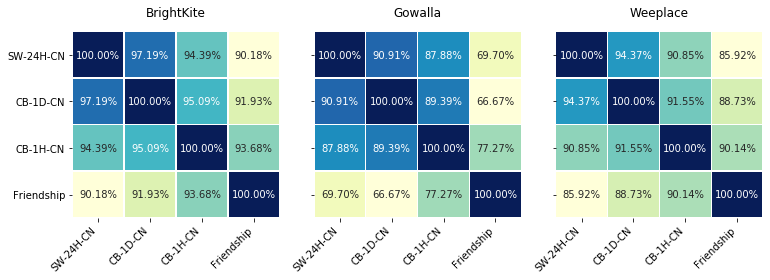

In [169]:
fig, axn = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    sns.heatmap(final[i], ax=ax, linewidths=.5, annot=True, fmt=".2%", cbar=False, cmap="YlGnBu"
#                 cbar=i == 0,
#                 vmin=0.77, vmax=1,
#                 cbar_ax=None if i else cbar_ax
               )
    ax.xaxis.set_label_position('bottom')
    ax.set_title(datasets[i], pad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
fig.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('fig/VIP_T_Test_MeetupNp.pdf')

In [57]:
# CI computation

In [37]:
# Only for PI
lower = df_all_used.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper = df_all_used.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid = df_all_used.groupby(['Included', 'category',
                           'dataset'])['Pi_alters_ratio'].mean().reset_index()

In [38]:
# Only for CCE
lower_CCE = df_all_used.groupby(['Included', 'category',
                         'dataset'])['CCE_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
upper_CCE = df_all_used.groupby(['Included', 'category',
                         'dataset'])['CCE_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
mid_CCE = df_all_used.groupby(['Included', 'category',
                           'dataset'])['CCE_alters_ratio'].mean().reset_index()

In [64]:
all_final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), 
                   [mid, lower, upper, mid_CCE, lower_CCE, upper_CCE])
all_final.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper','mean_CCE', 'lower_CCE', 'upper_CCE']

In [65]:
# all_final.to_csv('final/150_all_category_CP.csv', index=False)
all_final.to_csv('final/150_all_category_MeetupNp.csv', index=False)
# all_final.to_csv('final/FreqNp_Rank/150_all_category_FreqNp.csv', index=False)

# All these MFNs and TFN (Global Jaccard Similarity)

In [119]:
import pickle
import matplotlib.pyplot as plt

In [132]:
# pickle_in = open("final/wp-150/wp_VIP_similarity_CP.pickle", "rb")
# wp_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("final/bk-150/bk_VIP_similarity_CP.pickle", "rb")
# bk_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("final/gws-150/gws_VIP_similarity_CP.pickle", "rb")
# gws_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

pickle_in = open("final/wp-150/wp_VIP_similarity_MeetupNp.pickle", "rb")
wp_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("final/bk-150/bk_VIP_similarity_MeetupNp.pickle", "rb")
bk_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("final/gws-150/gws_VIP_similarity_MeetupNp.pickle", "rb")
gws_vip_similarity = pickle.load(pickle_in)
pickle_in.close()

# pickle_in = open("final/wp-150/wp_VIP_similarity_FreqNp.pickle", "rb")
# wp_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("final/bk-150/bk_VIP_similarity_FreqNp.pickle", "rb")
# bk_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

# pickle_in = open("final/gws-150/gws_VIP_similarity_FreqNp.pickle", "rb")
# gws_vip_similarity = pickle.load(pickle_in)
# pickle_in.close()

In [133]:
df = [bk_vip_similarity, gws_vip_similarity, wp_vip_similarity]

In [134]:
datasets = ['BrightKite', 'Gowalla', 'Weeplace']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if sys.path[0] == '':


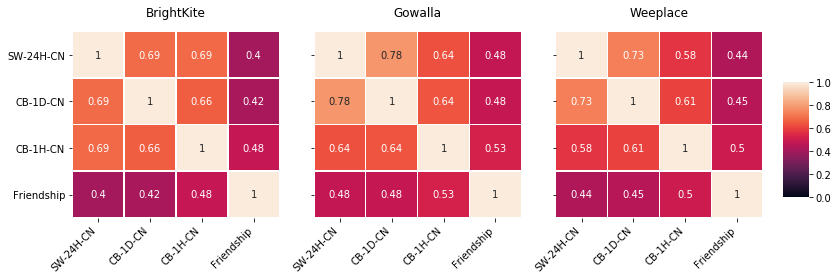

In [136]:
fig, axn = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
for i, ax in enumerate(axn.flat):
    sns.heatmap(df[i], ax=ax, linewidths=.5, annot=True,
                cbar=i == 0,
                vmin=0, vmax=1,
                cbar_ax=None if i else cbar_ax)
    ax.xaxis.set_label_position('bottom')
    ax.set_title(datasets[i], pad=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
fig.tight_layout(rect=[0, 0, .9, 1])
# plt.savefig('fig/VIP_similarity_FreqNp.pdf')
plt.savefig('fig/VIP_similarity_MeetupNp.pdf')

# VIP LR

In [69]:
# wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_LR_CP.csv')
# wp_vip_LR['dataset'] = 'Weeplace'

# bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_LR_CP.csv')
# bk_vip_LR['dataset'] = 'BrightKite'

# gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_LR_CP.csv')
# gw_vip_LR['dataset'] = 'Gowalla'

# wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_LR_MeetupNp.csv')
# wp_vip_LR['dataset'] = 'Weeplace'

# bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_LR_MeetupNp.csv')
# bk_vip_LR['dataset'] = 'BrightKite'

# gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_LR_MeetupNp.csv')
# gw_vip_LR['dataset'] = 'Gowalla'

# wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_LR_FreqNp.csv')
# wp_vip_LR['dataset'] = 'Weeplace'

# bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_LR_FreqNp.csv')
# bk_vip_LR['dataset'] = 'BrightKite'

# gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_LR_FreqNp.csv')
# gw_vip_LR['dataset'] = 'Gowalla'

wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_cumulative_LR_MeetupNp.csv')
wp_vip_LR['dataset'] = 'Weeplace'

bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_cumulative_LR_MeetupNp.csv')
bk_vip_LR['dataset'] = 'BrightKite'

gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_cumulative_LR_MeetupNp.csv')
gw_vip_LR['dataset'] = 'Gowalla'

# wp_vip_LR =  pd.read_csv('final/wp-150/wp_VIP_cumulative_LR_FreqNp.csv')
# wp_vip_LR['dataset'] = 'Weeplace'

# bk_vip_LR = pd.read_csv('final/bk-150/bk_VIP_cumulative_LR_FreqNp.csv')
# bk_vip_LR['dataset'] = 'BrightKite'

# gw_vip_LR = pd.read_csv('final/gws-150/gws_VIP_cumulative_LR_FreqNp.csv')
# gw_vip_LR['dataset'] = 'Gowalla'

In [70]:
vip_LR = pd.concat([wp_vip_LR, bk_vip_LR, gw_vip_LR])

In [107]:
vip_lower = vip_LR.groupby(['Included', 'category',
                         'dataset'])['USLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_LR.groupby(['Included', 'category',
                         'dataset'])['USLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_LR.groupby(['Included', 'category', 'dataset'])['USLR'].mean().reset_index()
vip_USLR = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_USLR.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']
vip_USLR['LR'] = 'USLR'

In [108]:
vip_lower = vip_LR.groupby(['Included', 'category',
                         'dataset'])['SLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_LR.groupby(['Included', 'category',
                         'dataset'])['SLR'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_LR.groupby(['Included', 'category', 'dataset'])['SLR'].mean().reset_index()

vip_SLR = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_SLR.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']
vip_SLR['LR'] = 'SLR'

In [109]:
vip_LR_final = pd.concat([vip_USLR, vip_SLR])

In [110]:
# vip_LR_final.to_csv('final/150_all_LR_CP.csv', index=False)
# vip_LR_final.to_csv('final/150_all_LR_MeetupNp.csv', index=False)
# vip_LR_final.to_csv('final/150_all_LR_FreqNp.csv', index=False)

vip_LR_final.to_csv('final/150_all_cumulative_LR_MeetupNp.csv', index=False)

# vip_LR_final.to_csv('final/150_all_cumulative_LR_FreqNp.csv', index=False)

In [72]:
category

['CB-1H-MFN', 'CB-1D-MFN', 'TFN', 'SW-24H-MFN']

In [107]:
for ds in ds_list:
    count_t = 0
    df_temp = vip_LR[vip_LR['dataset'] == ds]
    ur_ds = df_temp['userid'].unique().tolist()
    for user in ur_ds:
        temp_user = df_temp[df_temp['userid'] == user]
        MFN_H = temp_user[temp_user['category'] == category[0]]['USLR']
        TFN = temp_user[temp_user['category'] == category[2]]['USLR']
        
        coef_t, p_t = ttest_ind(MFN_H, TFN)  
        
        if p_t > 0.05:
            count_t +=1
    
    print(ds, count_t, count_t/len(ur_ds)*100, len(ur_ds))

Weeplace 271 95.08771929824562 285
BrightKite 59 89.39393939393939 66
Gowalla 131 92.25352112676056 142


# H-MFN vs TFN Cross validation

In [112]:
wp_vip_cv =  pd.read_csv('final/wp-150-cv/wp_join_vip10_CV_MeetupNp.csv')
wp_vip_cv['dataset'] = 'Weeplace'

bk_vip_cv = pd.read_csv('final/bk-150-cv/bk_join_vip10_CV_MeetupNp.csv')
bk_vip_cv['dataset'] = 'BrightKite'

gw_vip_cv = pd.read_csv('final/gws-150-cv/gws_join_vip10_CV_MeetupNp.csv')
gw_vip_cv['dataset'] = 'Gowalla'

In [113]:
vip_CV = pd.concat([wp_vip_cv, bk_vip_cv, gw_vip_cv])

In [117]:
vip_lower = vip_CV.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[0]).reset_index()
vip_upper = vip_CV.groupby(['Included', 'category',
                         'dataset'])['Pi_alters_ratio'].apply(lambda x: ci(sns.algorithms.bootstrap(x), 
                                                                           which=95)[1]).reset_index()
vip_mid = vip_CV.groupby(['Included', 'category', 'dataset'])['Pi_alters_ratio'].mean().reset_index()
vip_CV_final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Included', 'category', 'dataset']), [vip_mid, vip_lower, vip_upper])
vip_CV_final.columns = ['included', 'category', 'dataset', 'mean', 'lower', 'upper']

In [118]:
vip_CV_final.to_csv('final/150_all_CV_MeetupNp.csv', index=False)